In [1]:
using Base.Threads
using Distributions
using HypothesisTests
using QuadGK
using Random
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, guidefontsize=8, tickfontsize=6)

In [2]:
function prob_x_le_y(distx, disty, a=0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

function tieshift(distx, disty; probtie=0.5)
    #s = max(std(distx), std(disty))
    #m = median(distx) - median(disty)
    #find_zero(a -> prob_x_le_y(distx, disty, a) - probtie,
    #    (amin, amax), Bisection())
    find_zero(a -> prob_x_le_y(distx, disty, a) - probtie, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [3]:
distx, disty = Gamma(6, 1), Gamma(2, 3)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (5.670161188712071, 5.035040970049984)
median(distx) - median(disty) = 0.6351202186620872
tieshift(distx, disty) = 0.6001914280974744


In [4]:
function sim(TestFunc = MannWhitneyUTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6)
    pval = Vector{Float64}(undef, L)
    tmpX = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpY = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(distx, tmpX[threadid()])
        Y = rand!(disty, tmpY[threadid()])
        pval[i] = pvalue(TestFunc(X, Y))
    end
    pval
    ecdf(pval)
end

distname(dist) = replace(string(dist), r"\{[^\}]*\}"=>"")

function plot_ecdf(ecdf_pval, TestFunc, distx, disty, m, n; kwargs...)
    plot(p -> ecdf_pval(p), 0, 0.1; label="ecdf of P-values")
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(legend=:topleft)
    plot!(xtick=0:0.01:0.1, ytick=0:0.01:0.2)
    plot!(xguide="nominal significance level α", 
        yguide="probability of P-value < α")
    title!("$TestFunc\n\
        X: $(distname(distx)), m=$m\n\
        Y: $(distname(disty)), n=$n")
    plot!(size=(400, 450))
    plot!(; kwargs...)
end

function plot_pvals(
        TestFunc1 = MannWhitneyUTest,
        TestFunc2 = UnequalVarianceTTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6, kwargs...)
    
    @show a = tieshift(distx, disty)
    @show prob_x_le_y(distx, disty + a)
    ecdf_pval1 = @time sim(TestFunc1;
        distx = distx,
        disty = disty + a,
        m, n, L, kwargs...)
    ymax1 = ecdf_pval1(0.1)
    @show Δμ = mean(distx) - mean(disty)
    @show mean(distx), mean(distx + Δμ)
    ecdf_pval2 = @time sim(TestFunc2;
        distx = distx,
        disty = disty + Δμ,
        m, n, L, kwargs...)
    ymax2 = ecdf_pval2(0.1)
    ymax = max(ymax1, ymax2)
    P1 = plot_ecdf(ecdf_pval1, TestFunc1, distx, disty, m, n;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    P2 = plot_ecdf(ecdf_pval2, TestFunc2, distx, disty, m, n;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    plot(P1, P2; size=(800, 430))
end

plot_pvals (generic function with 3 methods)

## 正規分布

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.974456 seconds (8.06 M allocations: 2.014 GiB, 27.69% gc time, 26.13% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.576390 seconds (9.42 M allocations: 230.612 MiB, 41.46% compilation time)


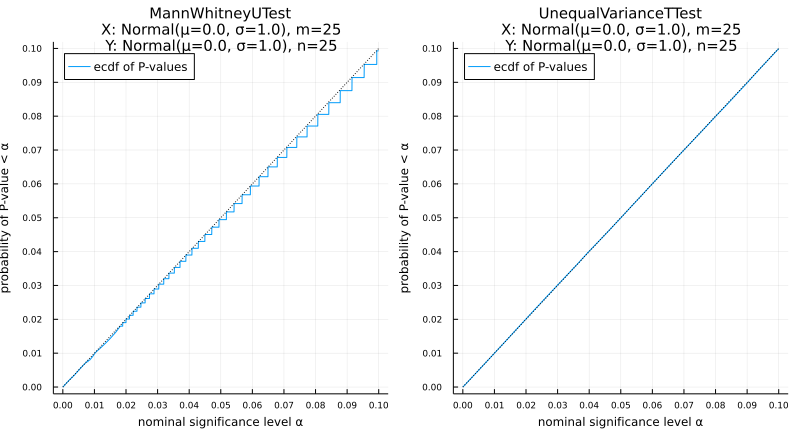

In [5]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 25, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.510533 seconds (7.00 M allocations: 2.690 GiB, 43.52% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.342508 seconds (9.00 M allocations: 206.012 MiB)


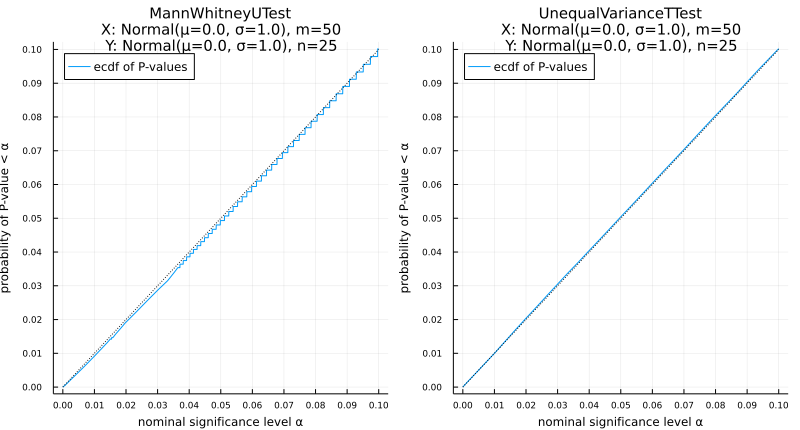

In [6]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 50, n = 25)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.360582 seconds (7.00 M allocations: 1.960 GiB, 37.48% gc time, 0.32% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.359774 seconds (9.00 M allocations: 206.009 MiB, 15.22% gc time)


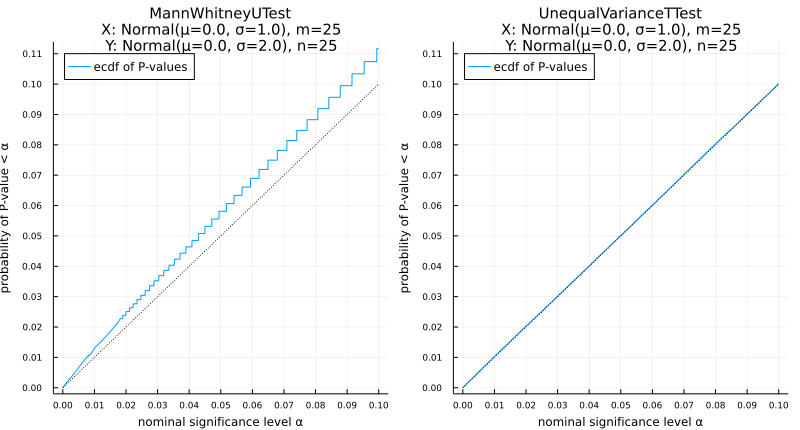

In [7]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 25, n = 25)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.514796 seconds (7.00 M allocations: 2.690 GiB, 42.06% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.380127 seconds (9.00 M allocations: 206.012 MiB, 13.92% gc time)


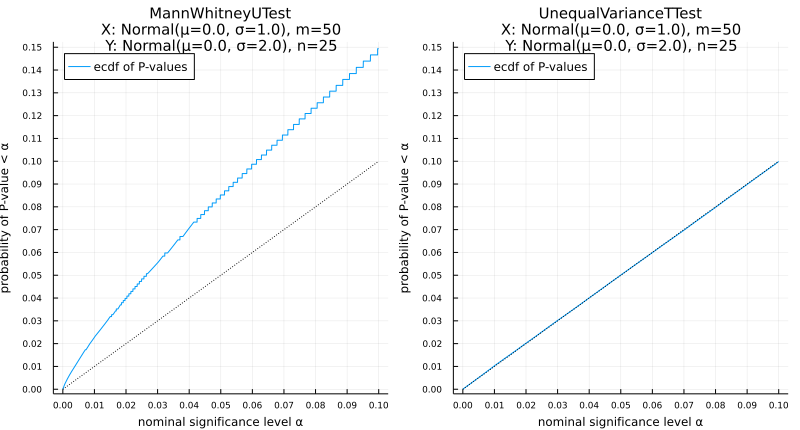

In [8]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.588621 seconds (7.00 M allocations: 1014.729 MiB, 29.90% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.352669 seconds (9.00 M allocations: 206.007 MiB, 20.41% gc time)


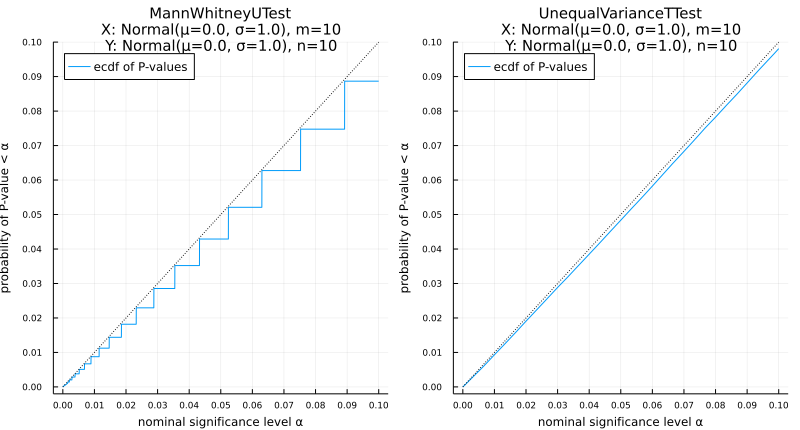

In [9]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.746101 seconds (7.00 M allocations: 1.289 GiB, 28.19% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.394270 seconds (9.00 M allocations: 206.007 MiB, 25.23% gc time)


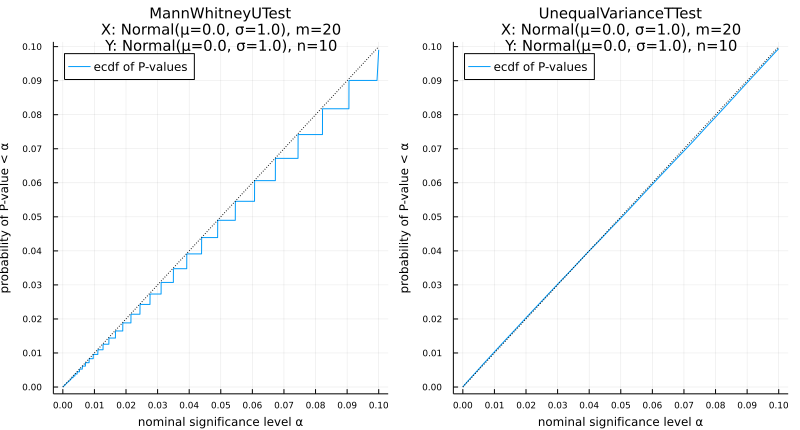

In [10]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 20, n = 10)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.604429 seconds (7.00 M allocations: 1014.730 MiB, 32.31% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.273228 seconds (9.00 M allocations: 206.007 MiB)


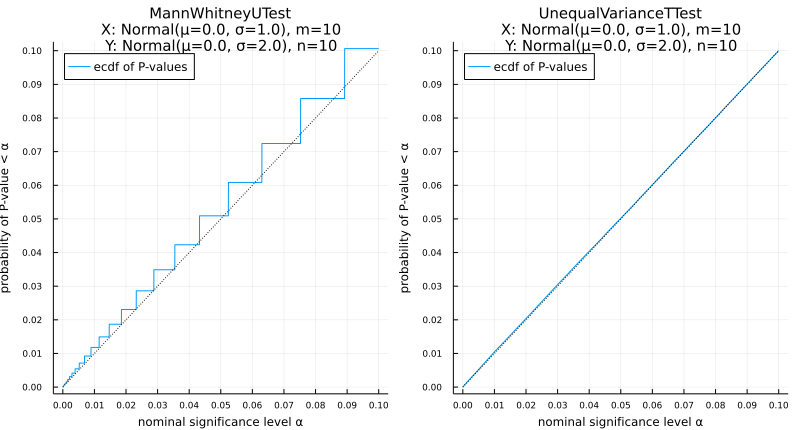

In [11]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.882581 seconds (7.00 M allocations: 1.289 GiB, 41.30% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.362457 seconds (9.00 M allocations: 206.007 MiB, 20.14% gc time)


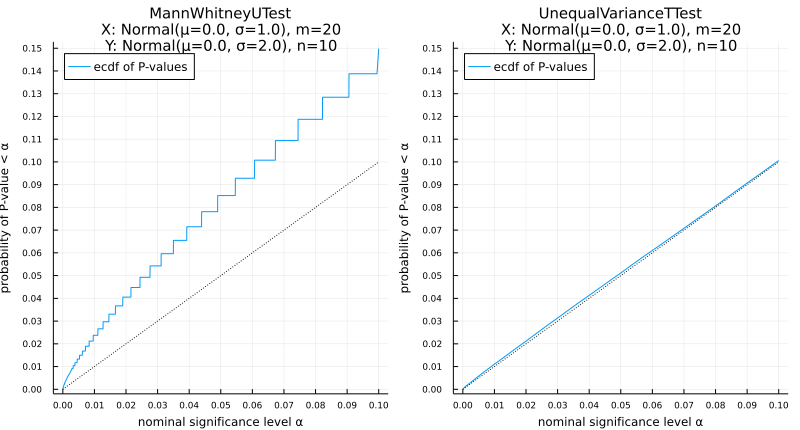

In [12]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 20, n = 10)

## ガンマ分布

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.622733 seconds (7.22 M allocations: 1.971 GiB, 23.66% gc time, 9.90% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.864120 seconds (9.07 M allocations: 211.142 MiB, 21.51% gc time, 15.81% compilation time)


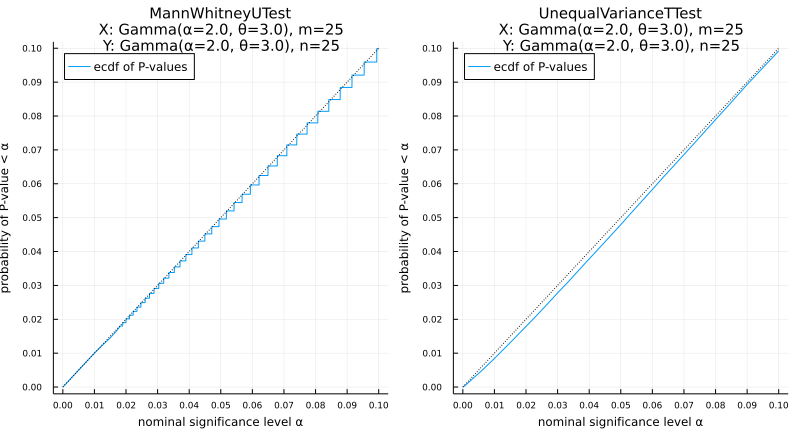

In [13]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 25, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.780590 seconds (7.00 M allocations: 2.690 GiB, 36.68% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.790430 seconds (9.00 M allocations: 206.012 MiB, 16.25% gc time)


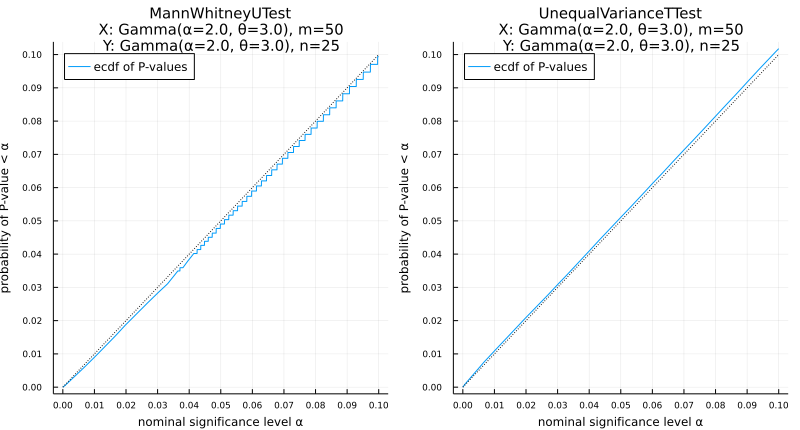

In [14]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 50, n = 25)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.518203 seconds (7.00 M allocations: 1.960 GiB, 29.72% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.576863 seconds (9.00 M allocations: 206.009 MiB, 11.03% gc time)


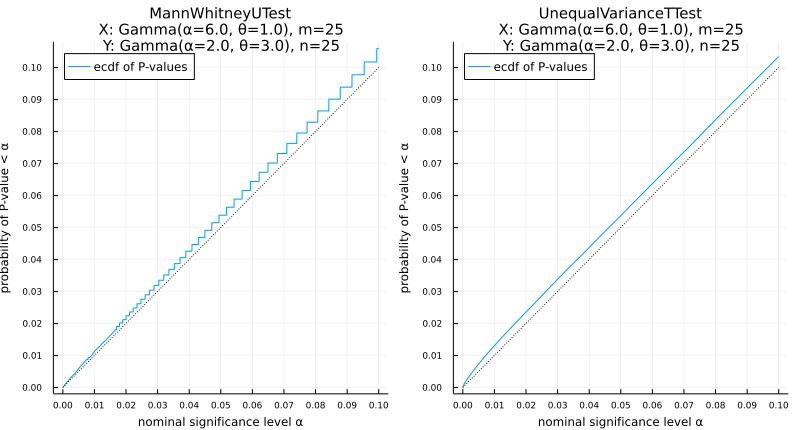

In [15]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 25, n = 25)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.661957 seconds (7.00 M allocations: 2.690 GiB, 36.71% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.577932 seconds (9.00 M allocations: 206.012 MiB)


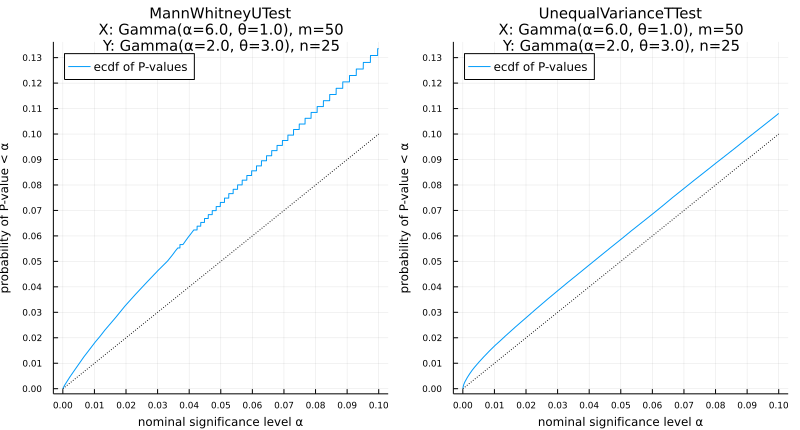

In [16]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.621328 seconds (7.00 M allocations: 1014.730 MiB, 22.64% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.607917 seconds (9.00 M allocations: 206.007 MiB, 36.15% gc time)


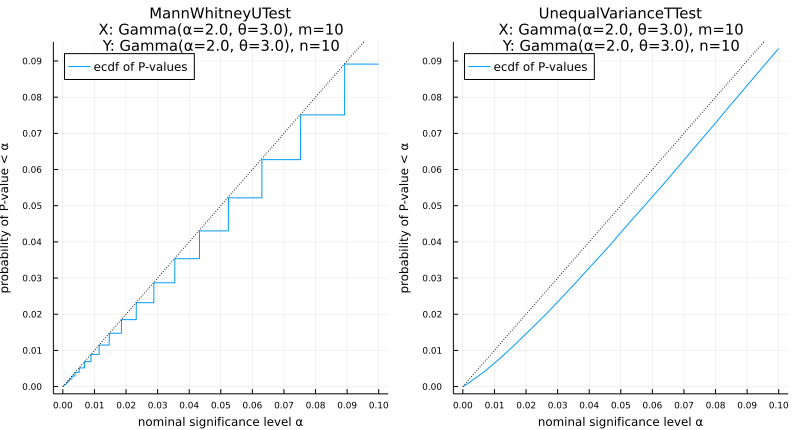

In [17]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.867041 seconds (7.00 M allocations: 1.289 GiB, 23.08% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.627876 seconds (9.00 M allocations: 206.008 MiB, 30.52% gc time)


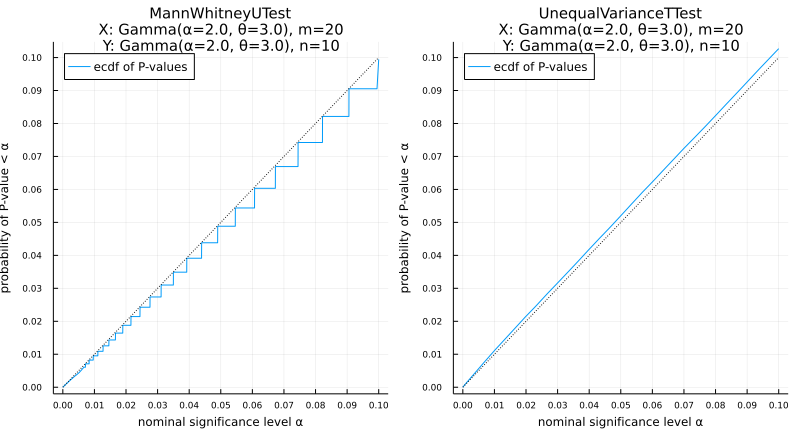

In [18]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 20, n = 10)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  0.807675 seconds (7.00 M allocations: 1014.729 MiB, 29.19% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.416003 seconds (9.00 M allocations: 206.007 MiB)


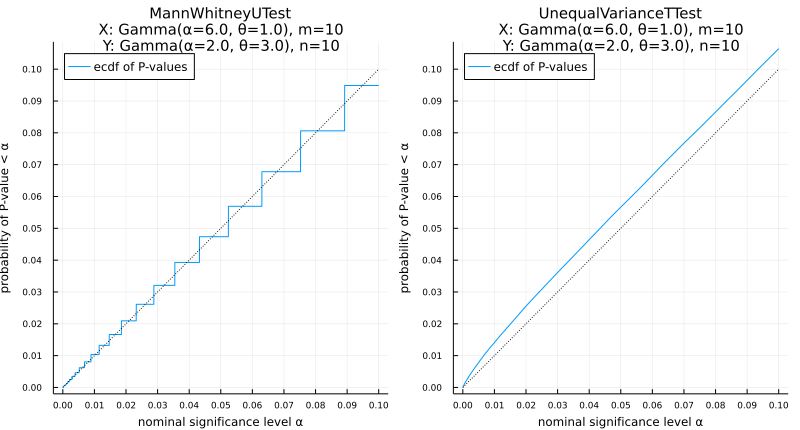

In [19]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 10, n = 10)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  0.932770 seconds (7.00 M allocations: 1.289 GiB, 34.33% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (6.0, 6.0)
  0.389084 seconds (9.00 M allocations: 206.007 MiB)


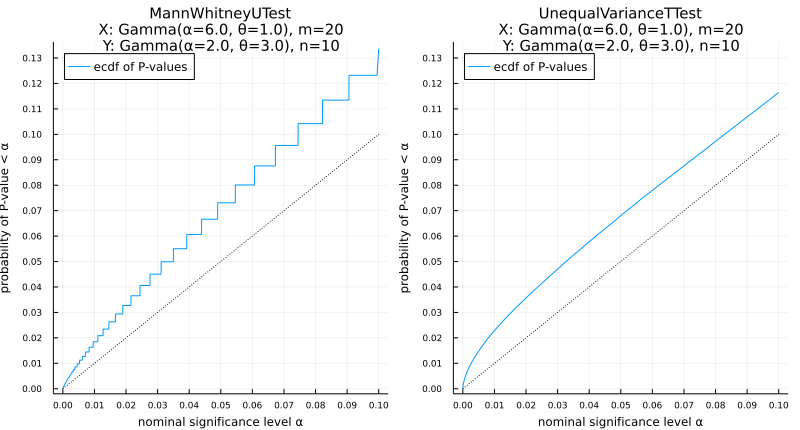

In [20]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 20, n = 10)

## 雑多

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.609769 seconds (7.06 M allocations: 1017.815 MiB, 25.59% gc time, 9.26% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.381785 seconds (9.07 M allocations: 211.198 MiB, 22.89% compilation time)


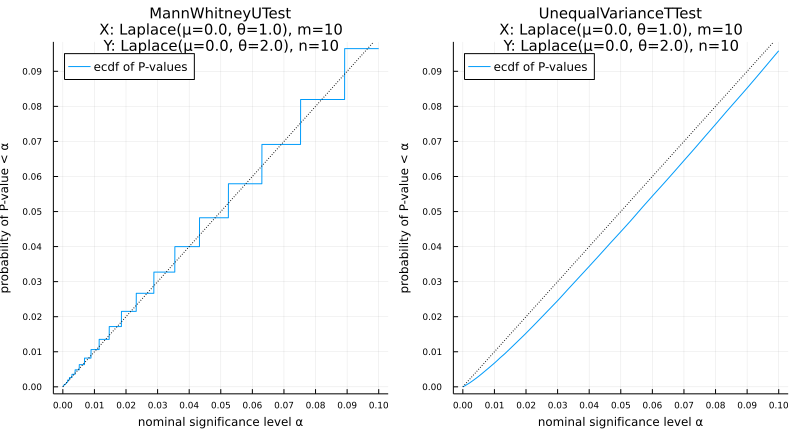

In [21]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.342226 seconds (7.00 M allocations: 1.960 GiB, 32.72% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.446698 seconds (9.00 M allocations: 206.009 MiB, 22.58% gc time)


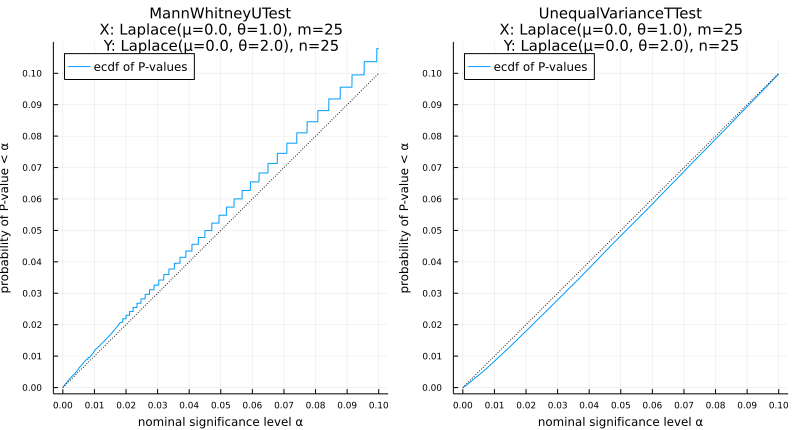

In [22]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 25, n = 25)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  2.004751 seconds (7.00 M allocations: 3.539 GiB, 41.06% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.620539 seconds (9.00 M allocations: 206.015 MiB, 28.64% gc time)


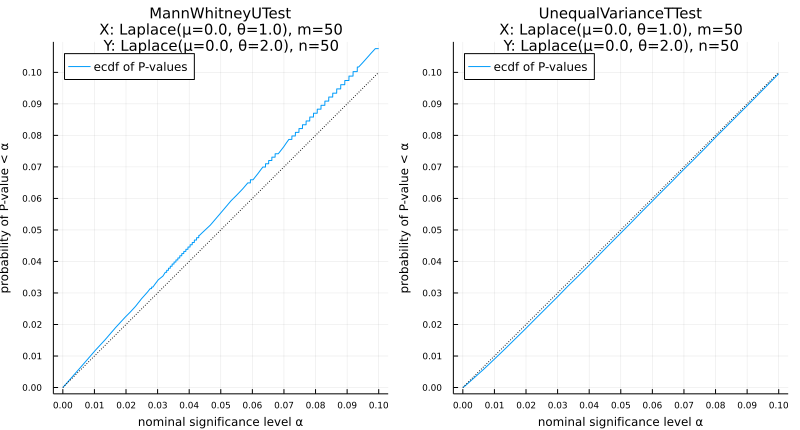

In [23]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 50)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.744980 seconds (7.00 M allocations: 1.289 GiB, 28.59% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.422674 seconds (9.00 M allocations: 206.007 MiB, 23.61% gc time)


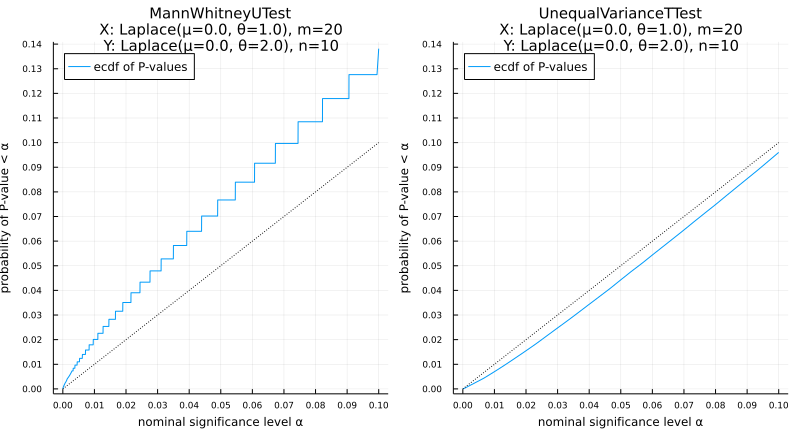

In [24]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 20, n = 10)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.488572 seconds (7.00 M allocations: 2.690 GiB, 39.44% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.479528 seconds (9.00 M allocations: 206.012 MiB, 17.23% gc time)


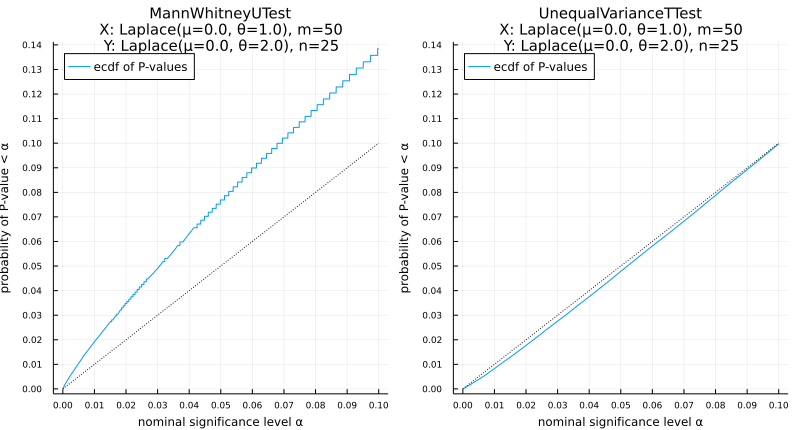

In [25]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.637585 seconds (7.59 M allocations: 1.018 GiB, 9.48% gc time, 28.81% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.629465 seconds (9.07 M allocations: 211.050 MiB, 38.33% gc time, 16.84% compilation time)


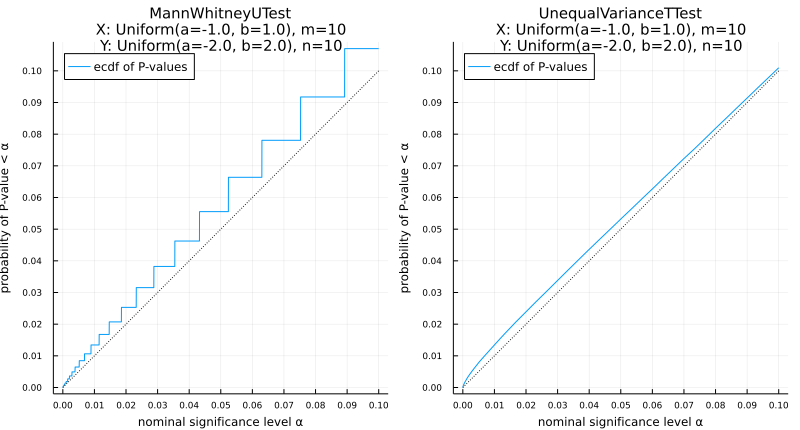

In [26]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.716071 seconds (7.00 M allocations: 1.289 GiB, 28.85% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.405939 seconds (9.00 M allocations: 206.007 MiB, 31.13% gc time)


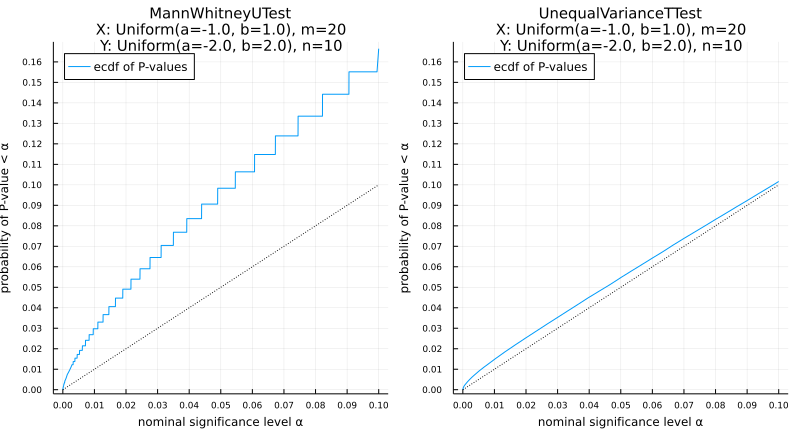

In [27]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 20, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.352913 seconds (7.00 M allocations: 2.690 GiB, 39.28% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  0.509595 seconds (9.00 M allocations: 206.012 MiB, 43.75% gc time)


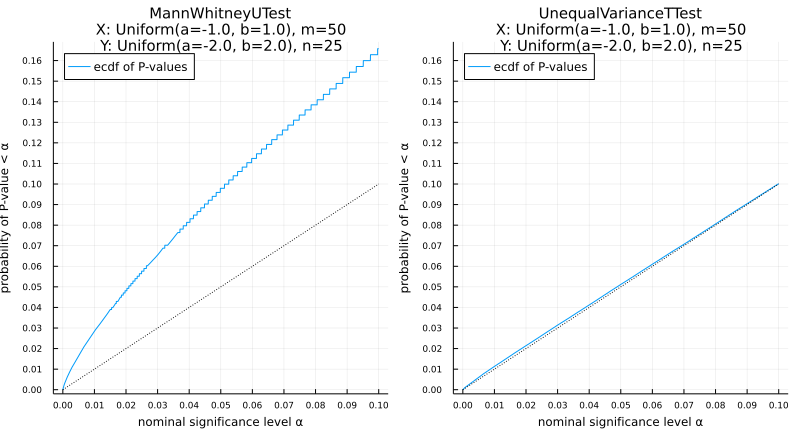

In [28]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 50, n = 25)

In [29]:
@doc LogNormal

```
LogNormal(μ,σ)
```

The *log normal distribution* is the distribution of the exponential of a [`Normal`](@ref) variate: if $X \sim \operatorname{Normal}(\mu, \sigma)$ then $\exp(X) \sim \operatorname{LogNormal}(\mu,\sigma)$. The probability density function is

$$
f(x; \mu, \sigma) = \frac{1}{x \sqrt{2 \pi \sigma^2}}
\exp \left( - \frac{(\log(x) - \mu)^2}{2 \sigma^2} \right),
\quad x > 0
$$

```julia
LogNormal()          # Log-normal distribution with zero log-mean and unit scale
LogNormal(μ)         # Log-normal distribution with log-mean mu and unit scale
LogNormal(μ, σ)      # Log-normal distribution with log-mean mu and scale sig

params(d)            # Get the parameters, i.e. (μ, σ)
meanlogx(d)          # Get the mean of log(X), i.e. μ
varlogx(d)           # Get the variance of log(X), i.e. σ^2
stdlogx(d)           # Get the standard deviation of log(X), i.e. σ
```

External links

  * [Log normal distribution on Wikipedia](http://en.wikipedia.org/wiki/Log-normal_distribution)


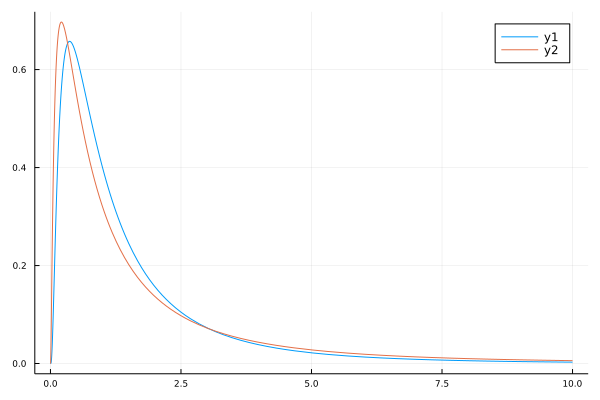

In [30]:
plot(LogNormal(0, 1), 0, 10)
plot!(LogNormal(0, 1.25), 0, 10)

In [31]:
std(LogNormal(0, 1)), std(LogNormal(0, 1.25))

(2.1611974158950877, 4.241363213821604)

a = tieshift(distx, disty) = 7.873419302111289e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.565826 seconds (753.28 k allocations: 3.060 GiB, 32.53% gc time, 3.79% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.324973 seconds (974.24 k allocations: 25.908 MiB, 25.60% compilation time)


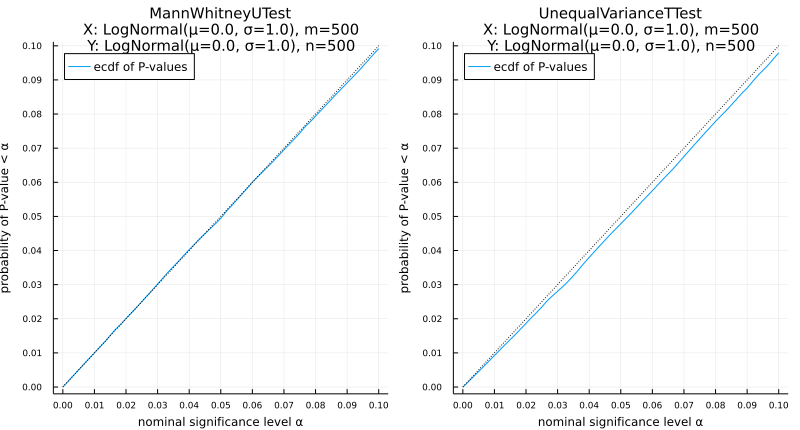

In [32]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1), m = 500, n = 500, L=10^5)

a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  1.746204 seconds (700.20 k allocations: 3.057 GiB, 41.92% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(distx + Δμ)) = (1.6487212707001282, 1.1132417305846385)
  0.242659 seconds (899.69 k allocations: 20.704 MiB)


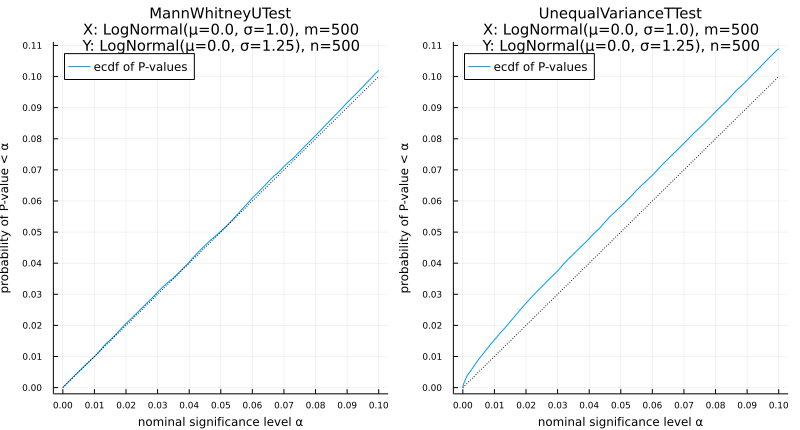

In [33]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 500, n = 500, L=10^5)

a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  2.612609 seconds (700.21 k allocations: 4.553 GiB, 37.82% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(distx + Δμ)) = (1.6487212707001282, 1.1132417305846385)
  0.355822 seconds (899.70 k allocations: 20.750 MiB)


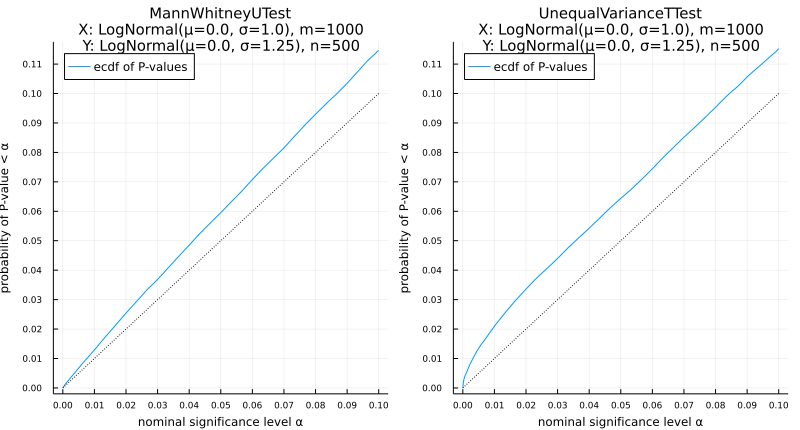

In [34]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 1000, n = 500, L=10^5)

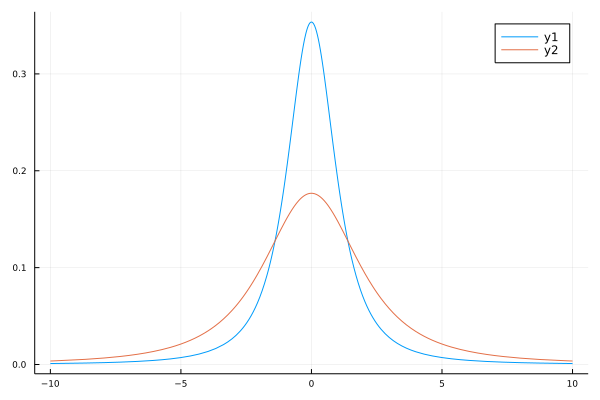

In [35]:
plot(TDist(2), -10, 10)
plot!(2TDist(2), -10, 10)

In [36]:
var(TDist(2)), var(TDist(3)), var(TDist(4)), var(TDist(5))

(Inf, 3.0, 2.0, 1.6666666666666667)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  4.444724 seconds (7.16 M allocations: 6.840 GiB, 40.45% gc time, 1.74% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  1.114688 seconds (9.07 M allocations: 211.228 MiB, 8.57% compilation time)


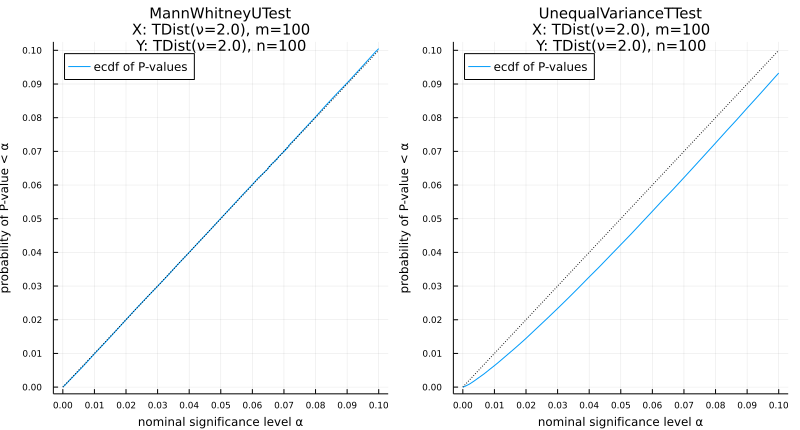

In [37]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 100, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  5.744844 seconds (7.00 M allocations: 9.783 GiB, 37.61% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  1.686793 seconds (9.00 M allocations: 206.034 MiB, 13.89% gc time)


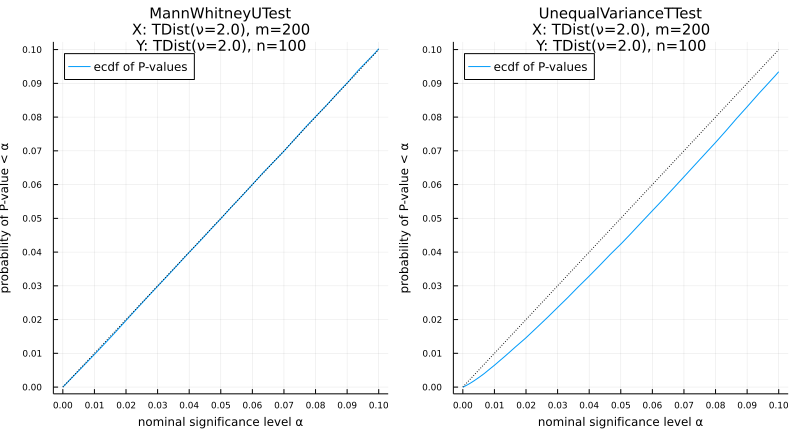

In [38]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 200, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  4.654341 seconds (7.00 M allocations: 6.832 GiB, 44.23% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  1.066991 seconds (9.00 M allocations: 206.024 MiB, 2.55% gc time)


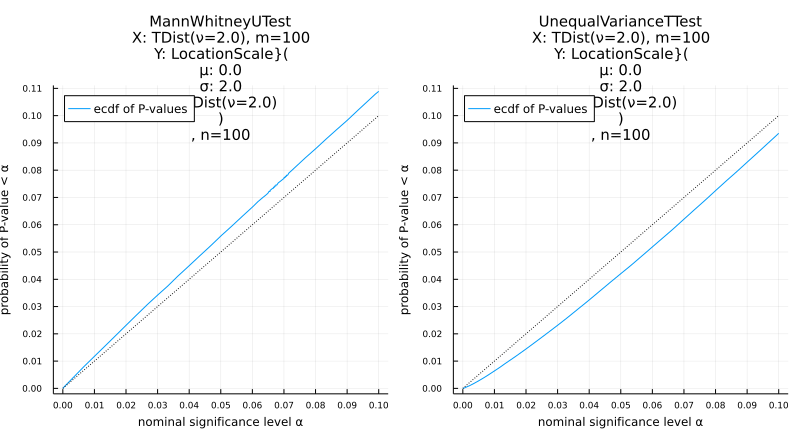

In [39]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 100, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  4.768147 seconds (7.00 M allocations: 9.783 GiB, 28.26% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(distx + Δμ)) = (0.0, 0.0)
  1.497732 seconds (9.00 M allocations: 206.034 MiB, 3.16% gc time)


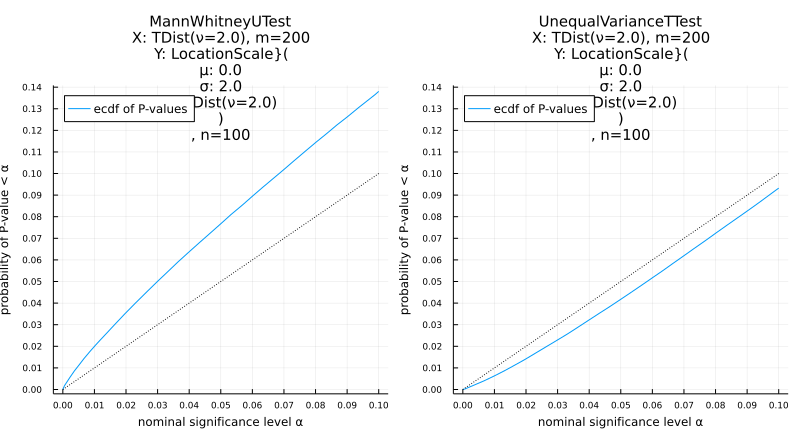

In [40]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 200, n = 100)